# Number Plate Detection using YOLOv3


## Importing necessary libraries

In [29]:
from IPython.display import Image
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [30]:
pip install opencv-python==4.5.3.56

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#path for testing data
input_path = r'/content/drive/MyDrive/License-Plate-Number-Detection-main/test_dataset/images/1.jpg'

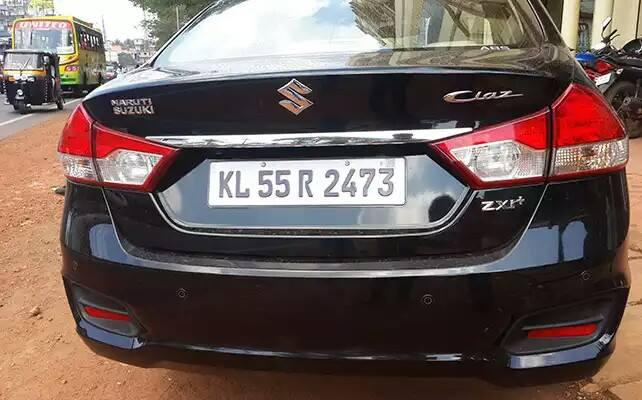

In [33]:
Image(input_path)

## Input Receiver

In [34]:
#Open the image file
cap = cv2.VideoCapture(input_path)

## YOLO Plate Detection

In [35]:
# Initialize the parameters

confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [36]:
# Load names of classes
classesFile = "/content/drive/MyDrive/License-Plate-Number-Detection-main/yolo_utils/classes.names";

In [37]:
# Append all different classes into the list 'classes'
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

### Restore the neural network

In [38]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = r"/content/drive/MyDrive/License-Plate-Number-Detection-main/yolo_utils/darknet-yolov3.cfg";
modelWeights = r"/content/drive/MyDrive/License-Plate-Number-Detection-main/yolo_utils/lapi.weights";

In [39]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights) #set up the model
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### Define the post processing functions

In [40]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [41]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [42]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

### Plate Detection

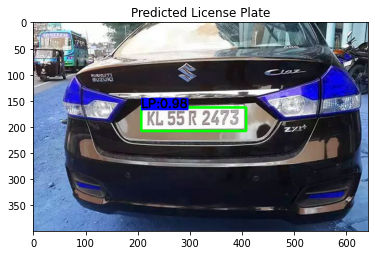

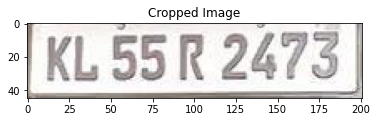

Done processing !!!


In [43]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        break

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted Number plate Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.show()

# Charecter Segmentation

In [44]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [45]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

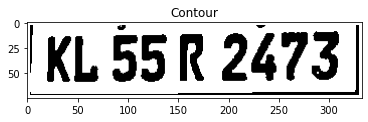

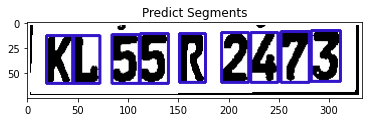

In [46]:
char=segment_characters(cropped)

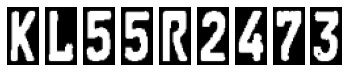

In [47]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Character Recognition using CNN

In [48]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('/content/drive/MyDrive/License-Plate-Number-Detection-main/checkpoints1/my_checkpoint')

## Predict the number plate number

In [49]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(loaded_model.predict(img), axis=-1)[0]
        #y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 28ms/step
KL55RZ473


1/1 [==============================] - 0s 30ms/step


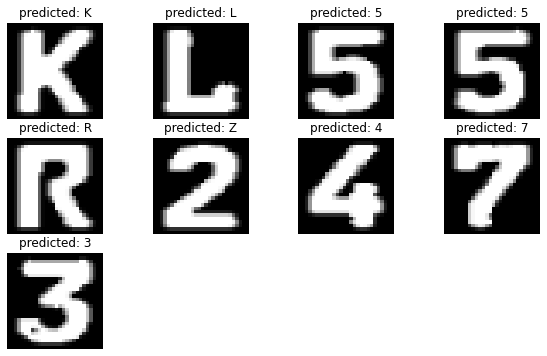

In [50]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset

In [51]:
labels=pd.read_excel('/content/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

ID       NUMBER
0      1.0    KL55R2473
1      2.0  GJW115A1138
2      3.0    KL16J3636
3      4.0   MH20EE7598
4      5.0      PJJ1L76
..     ...          ...
161  162.0      DHF5B15
162  163.0      DBJ5R59
163  164.0      LVY8X45
164  165.0      YYD6B61
165  166.0      CHI4A30

[166 rows x 2 columns]

In [52]:
labels['NUMBER'][0]

'KL55R2473'

In [53]:
def show_results1(char1):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char1): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(loaded_model.predict(img), axis=-1)[0]
        #y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

## Accuracy

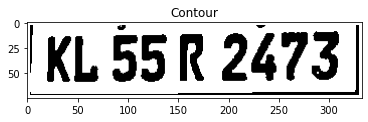

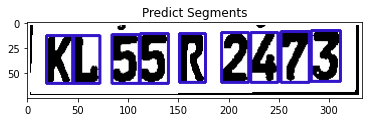

1/1 [==============================] - 0s 31ms/step


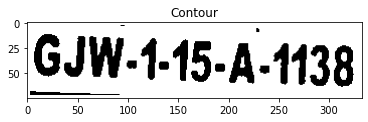

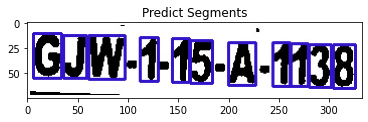

1/1 [==============================] - 0s 30ms/step


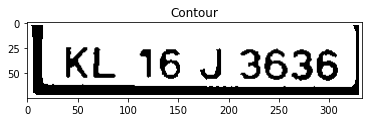

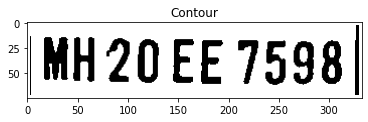

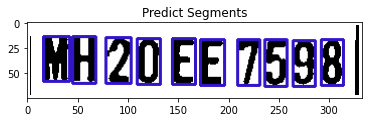

1/1 [==============================] - 0s 36ms/step


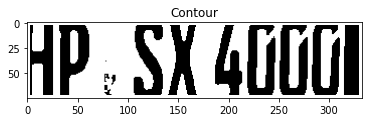

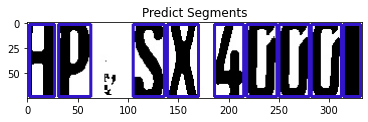

1/1 [==============================] - 0s 32ms/step


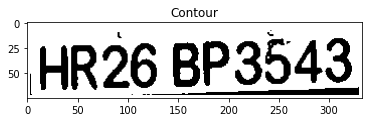

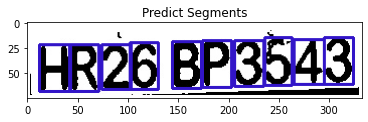

1/1 [==============================] - 0s 30ms/step


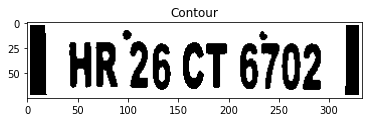

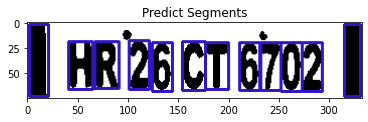

1/1 [==============================] - 0s 30ms/step


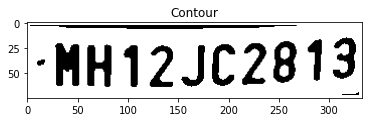

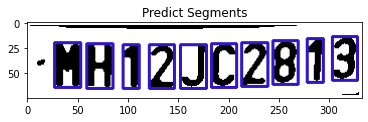

1/1 [==============================] - 0s 29ms/step


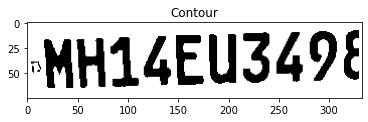

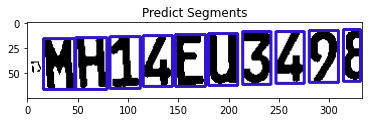

1/1 [==============================] - 0s 42ms/step


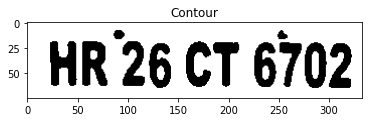

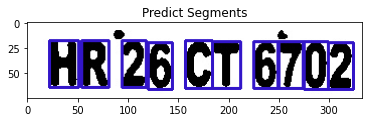

1/1 [==============================] - 0s 39ms/step


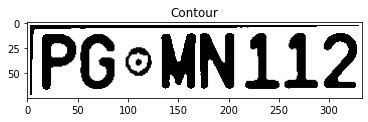

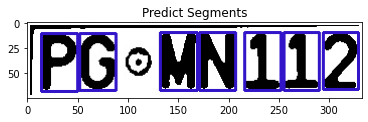

1/1 [==============================] - 0s 31ms/step


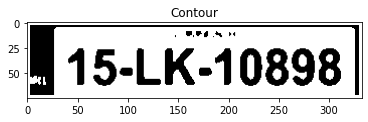

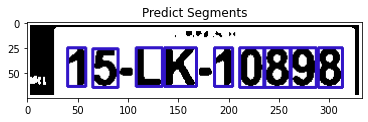

1/1 [==============================] - 0s 33ms/step


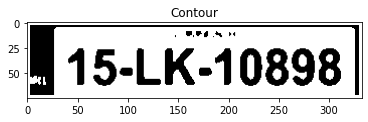

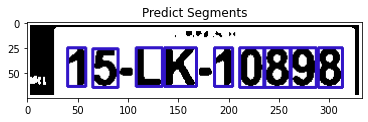

1/1 [==============================] - 0s 54ms/step


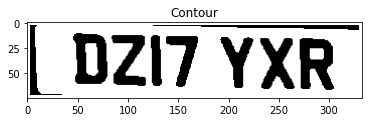

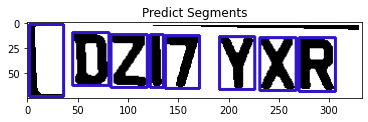

1/1 [==============================] - 0s 33ms/step


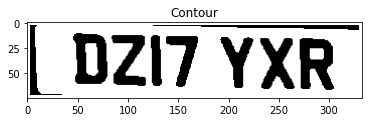

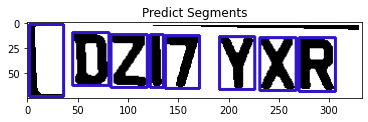

1/1 [==============================] - 0s 34ms/step


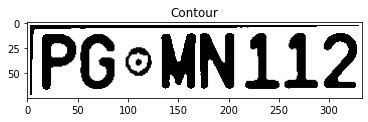

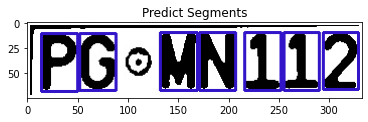

1/1 [==============================] - 0s 32ms/step


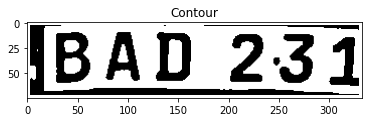

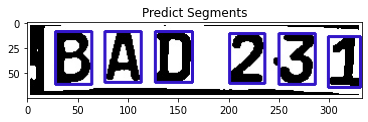

1/1 [==============================] - 0s 29ms/step


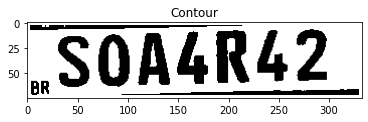

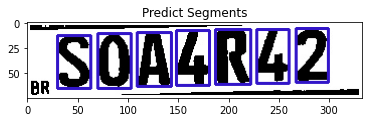

1/1 [==============================] - 0s 29ms/step


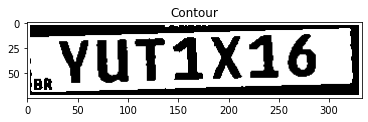

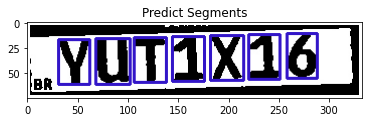

1/1 [==============================] - 0s 31ms/step


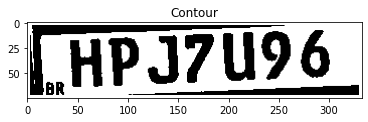

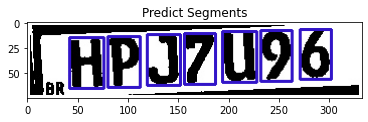

1/1 [==============================] - 0s 30ms/step


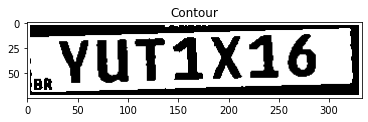

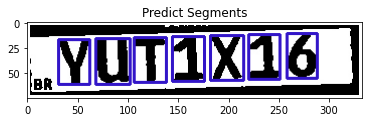

1/1 [==============================] - 0s 29ms/step


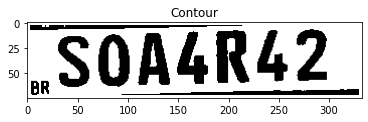

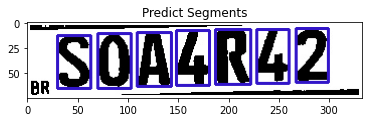

1/1 [==============================] - 0s 34ms/step


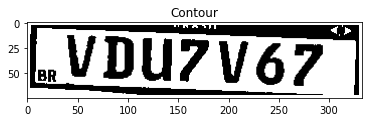

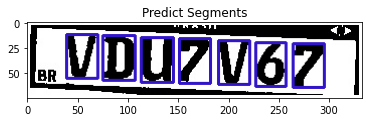

1/1 [==============================] - 0s 30ms/step


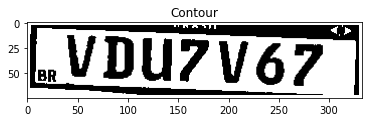

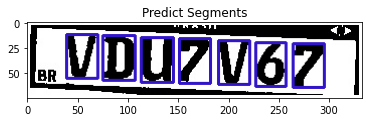

1/1 [==============================] - 0s 29ms/step


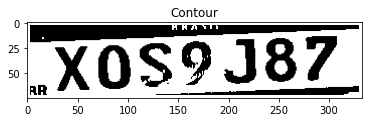

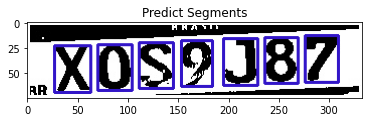

1/1 [==============================] - 0s 30ms/step


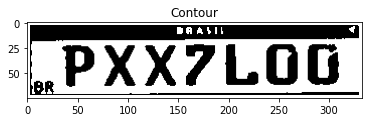

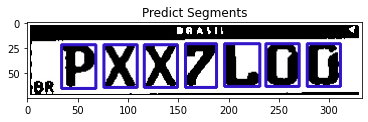

1/1 [==============================] - 0s 32ms/step


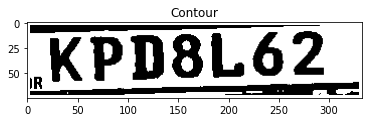

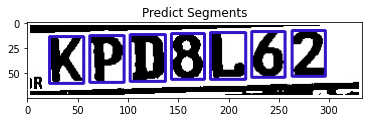

1/1 [==============================] - 0s 31ms/step


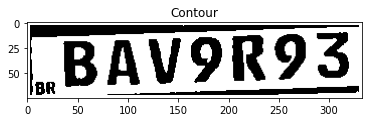

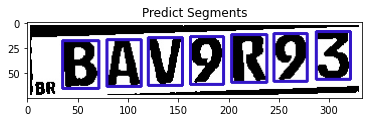

1/1 [==============================] - 0s 32ms/step


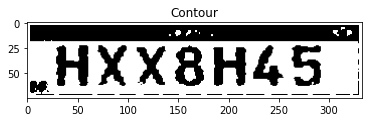

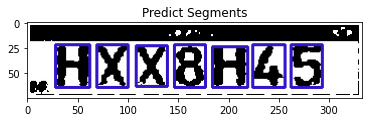

1/1 [==============================] - 0s 31ms/step


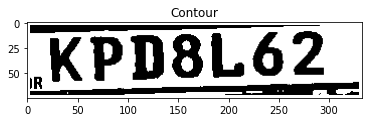

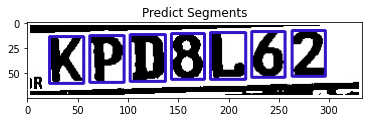

1/1 [==============================] - 0s 29ms/step


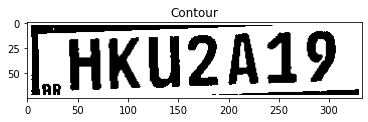

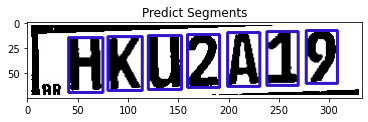

1/1 [==============================] - 0s 29ms/step


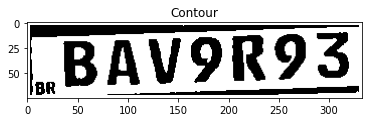

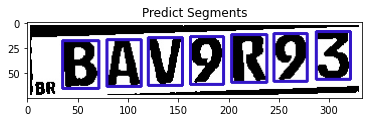

1/1 [==============================] - 0s 31ms/step


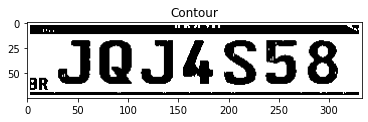

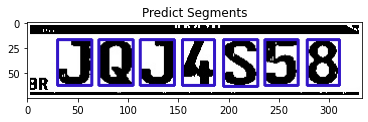

1/1 [==============================] - 0s 28ms/step


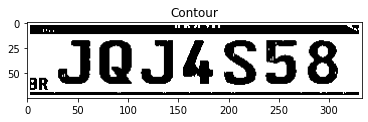

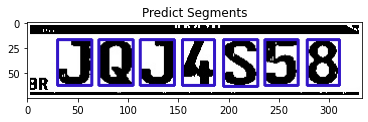

1/1 [==============================] - 0s 29ms/step


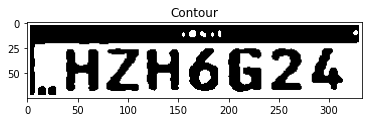

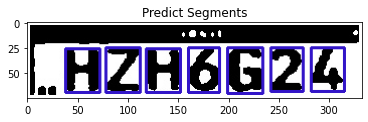

1/1 [==============================] - 0s 30ms/step


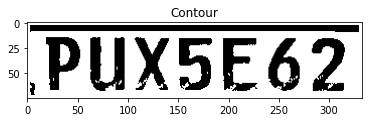

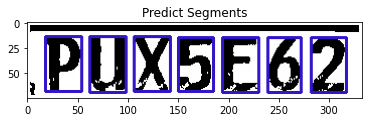

1/1 [==============================] - 0s 30ms/step


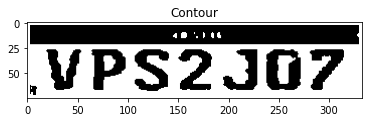

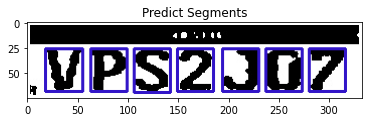

1/1 [==============================] - 0s 34ms/step


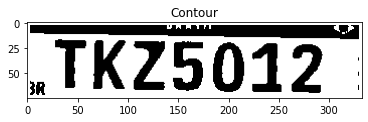

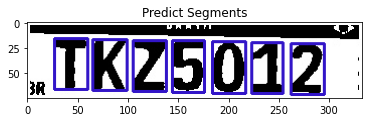

1/1 [==============================] - 0s 32ms/step


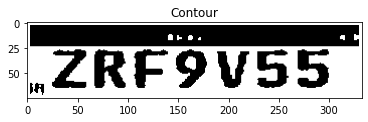

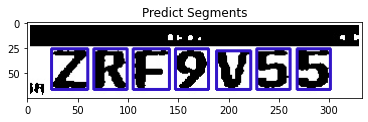

1/1 [==============================] - 0s 31ms/step


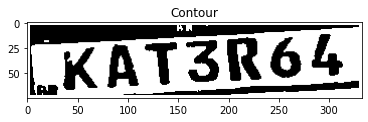

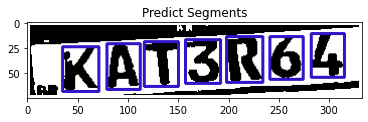

1/1 [==============================] - 0s 33ms/step


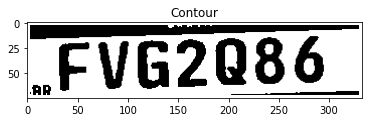

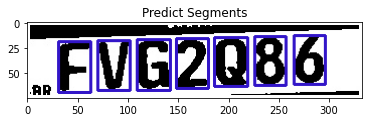

1/1 [==============================] - 0s 31ms/step


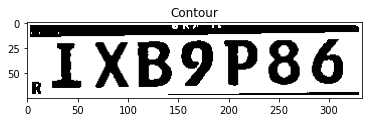

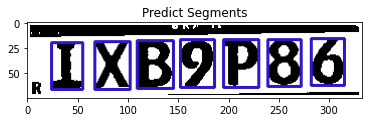

1/1 [==============================] - 0s 29ms/step


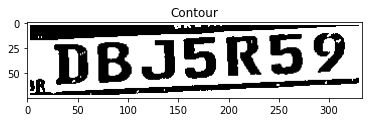

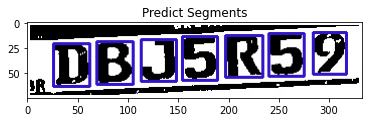

1/1 [==============================] - 0s 32ms/step


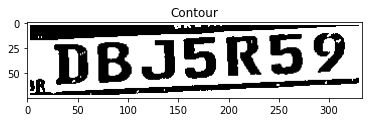

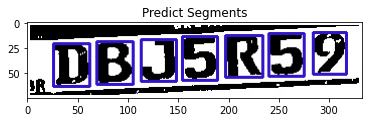

1/1 [==============================] - 0s 30ms/step


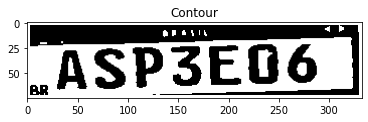

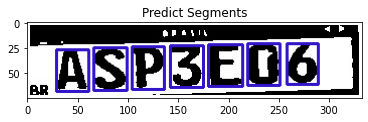

1/1 [==============================] - 0s 29ms/step


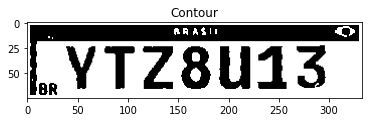

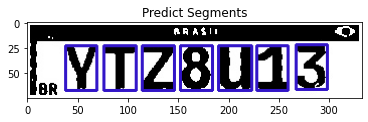

1/1 [==============================] - 0s 31ms/step


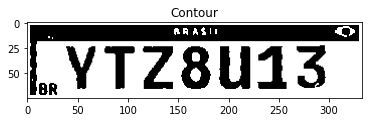

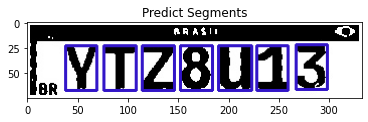

1/1 [==============================] - 0s 30ms/step


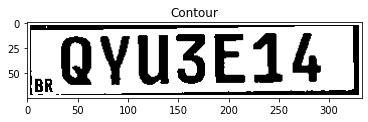

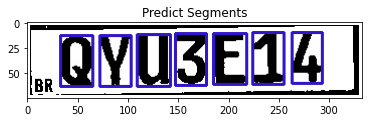

1/1 [==============================] - 0s 31ms/step


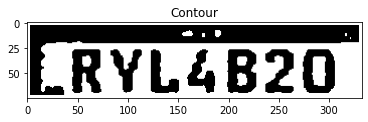

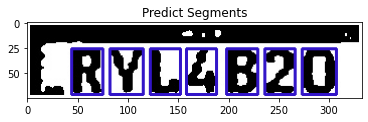

1/1 [==============================] - 0s 31ms/step


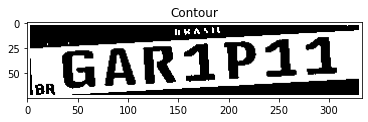

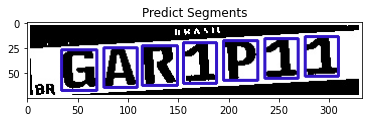

1/1 [==============================] - 0s 28ms/step


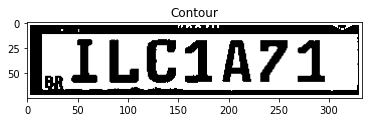

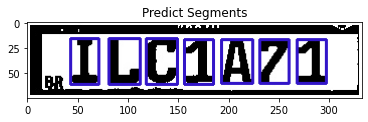

1/1 [==============================] - 0s 31ms/step


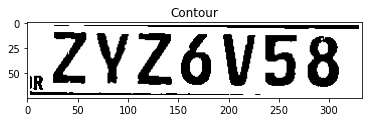

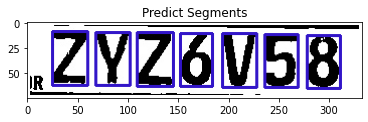

1/1 [==============================] - 0s 35ms/step


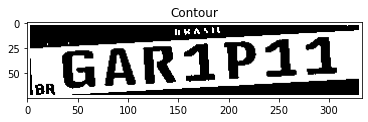

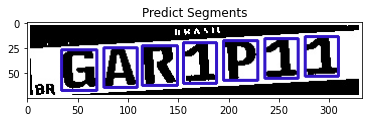

1/1 [==============================] - 0s 31ms/step


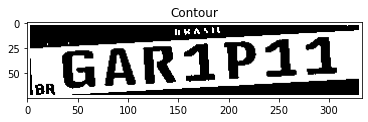

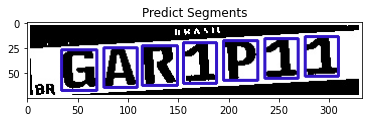

1/1 [==============================] - 0s 31ms/step


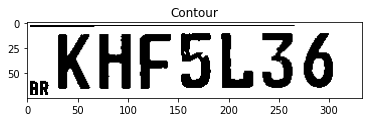

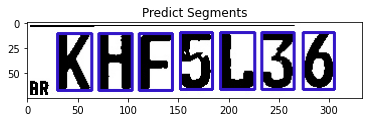

1/1 [==============================] - 0s 32ms/step


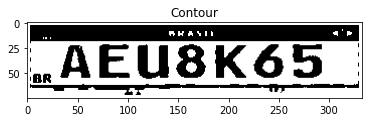

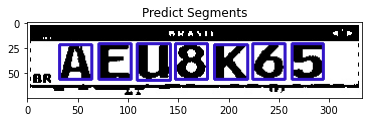

1/1 [==============================] - 0s 29ms/step


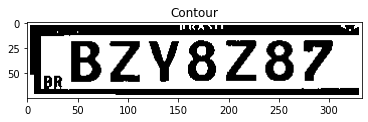

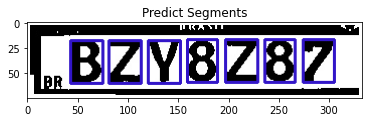

1/1 [==============================] - 0s 35ms/step


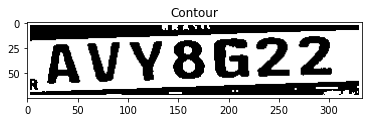

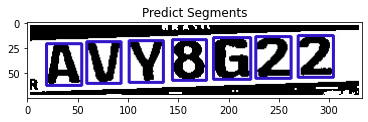

1/1 [==============================] - 0s 32ms/step


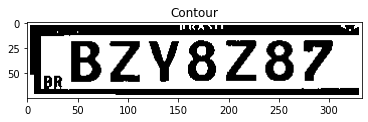

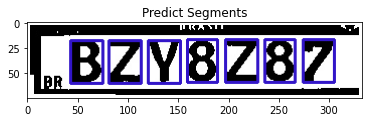

1/1 [==============================] - 0s 35ms/step


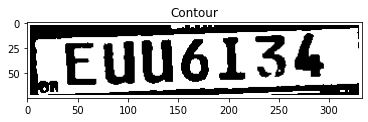

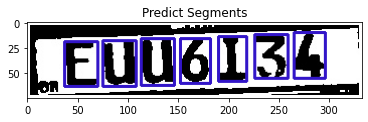

1/1 [==============================] - 0s 33ms/step


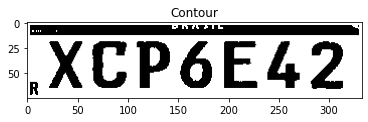

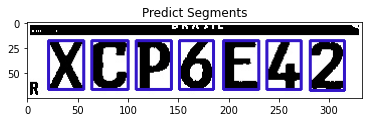

1/1 [==============================] - 0s 34ms/step


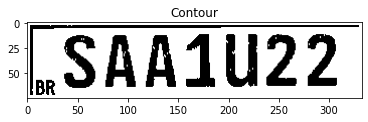

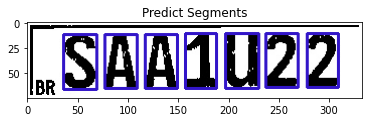

1/1 [==============================] - 0s 47ms/step


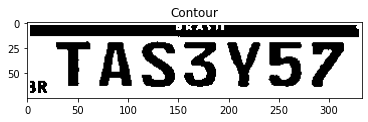

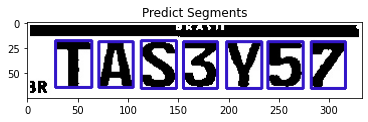

1/1 [==============================] - 0s 37ms/step


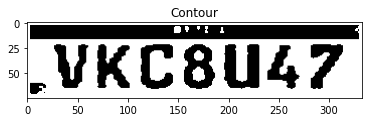

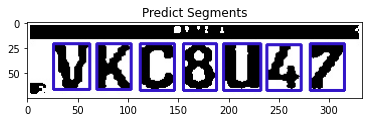

1/1 [==============================] - 0s 34ms/step


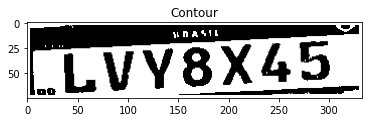

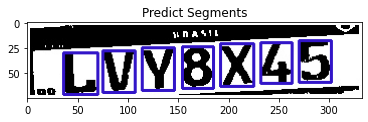

1/1 [==============================] - 0s 35ms/step


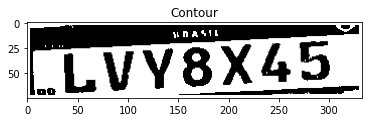

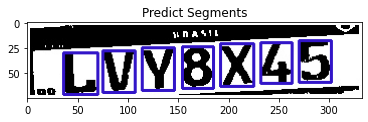

1/1 [==============================] - 0s 32ms/step


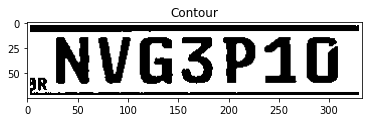

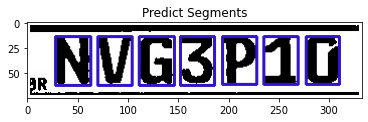

1/1 [==============================] - 0s 35ms/step


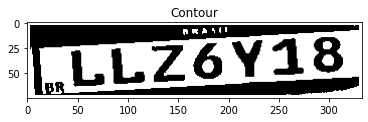

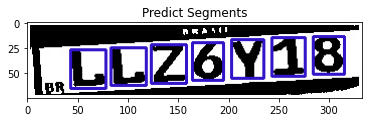

1/1 [==============================] - 0s 42ms/step


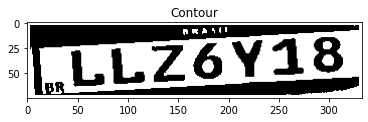

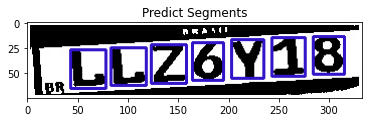

1/1 [==============================] - 0s 35ms/step


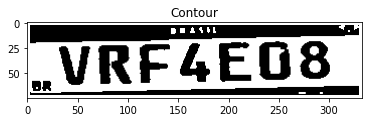

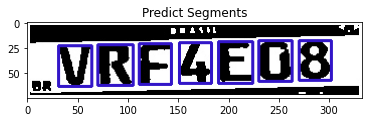

1/1 [==============================] - 0s 34ms/step


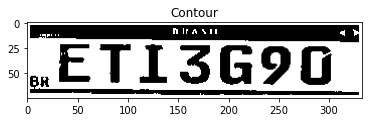

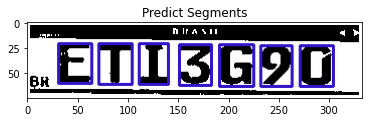

1/1 [==============================] - 0s 34ms/step


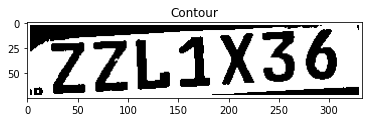

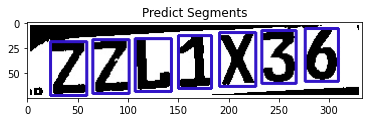

1/1 [==============================] - 0s 42ms/step


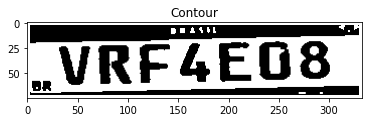

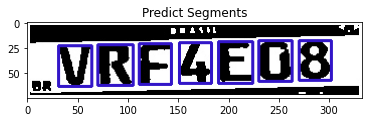

1/1 [==============================] - 0s 37ms/step


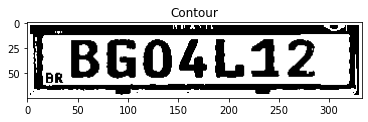

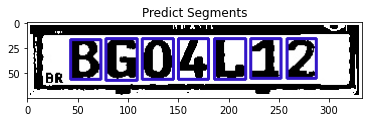

1/1 [==============================] - 0s 39ms/step


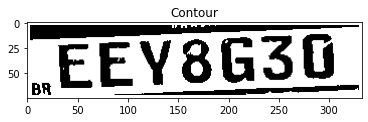

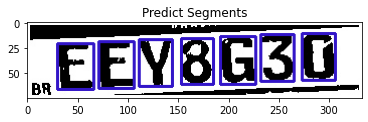

1/1 [==============================] - 0s 37ms/step


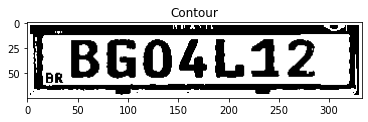

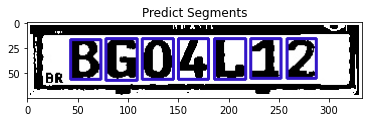

1/1 [==============================] - 0s 37ms/step


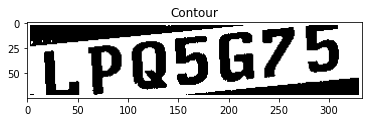

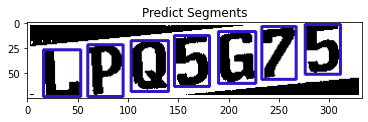

1/1 [==============================] - 0s 39ms/step


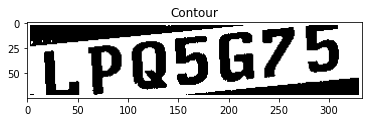

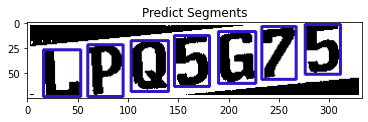

1/1 [==============================] - 0s 41ms/step


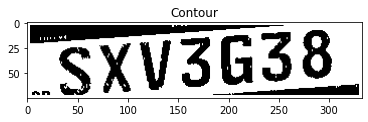

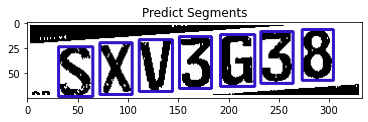

1/1 [==============================] - 0s 58ms/step


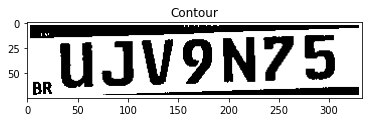

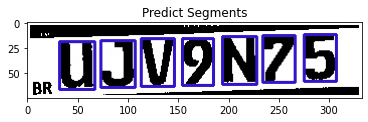

1/1 [==============================] - 0s 30ms/step


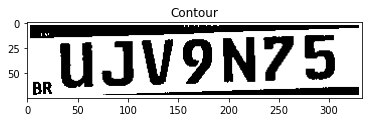

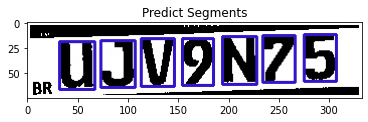

1/1 [==============================] - 0s 45ms/step


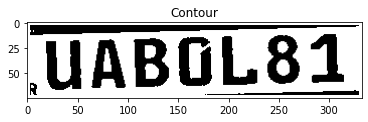

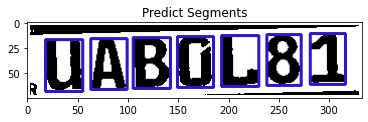

1/1 [==============================] - 0s 36ms/step


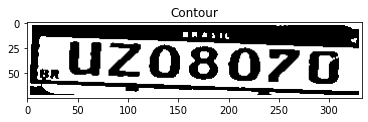

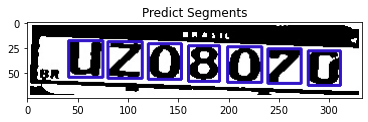

1/1 [==============================] - 0s 44ms/step


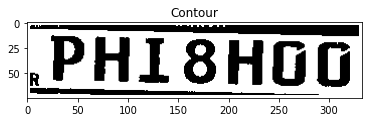

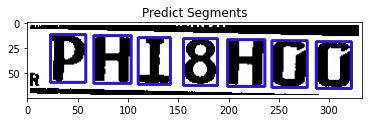

1/1 [==============================] - 0s 46ms/step


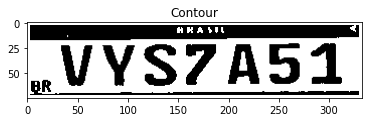

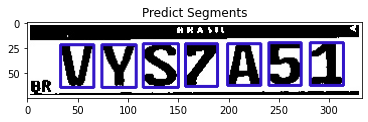

1/1 [==============================] - 0s 29ms/step


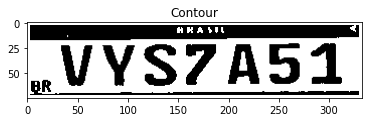

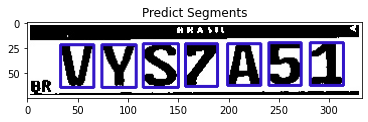

1/1 [==============================] - 0s 50ms/step


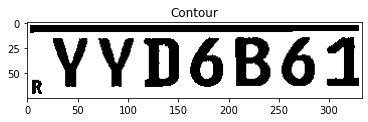

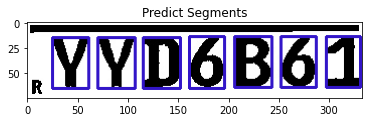

1/1 [==============================] - 0s 34ms/step


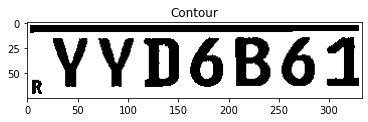

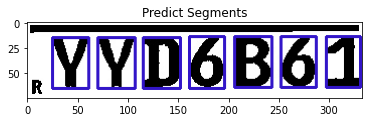

1/1 [==============================] - 0s 41ms/step


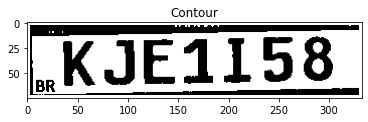

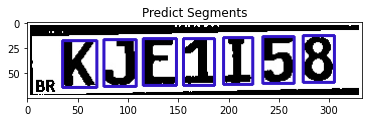

1/1 [==============================] - 0s 30ms/step


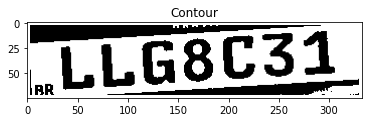

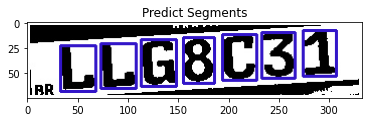

1/1 [==============================] - 0s 43ms/step


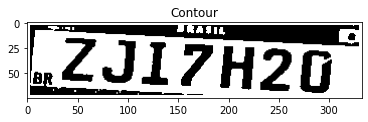

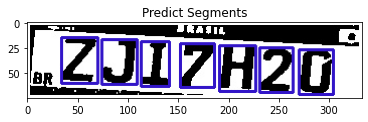

1/1 [==============================] - 0s 65ms/step


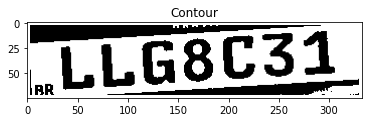

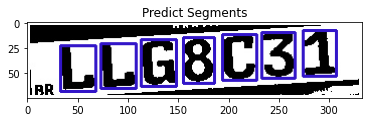

1/1 [==============================] - 0s 48ms/step


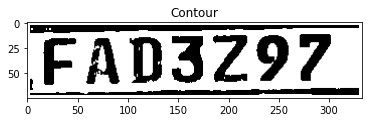

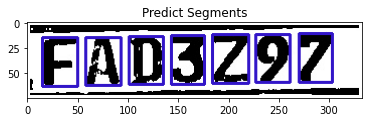

1/1 [==============================] - 0s 45ms/step


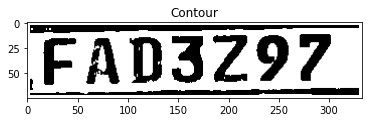

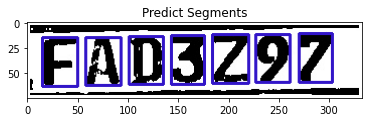

1/1 [==============================] - 0s 48ms/step


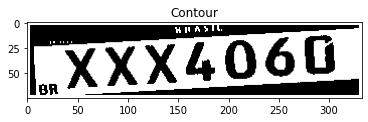

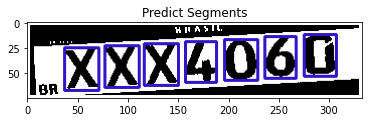

1/1 [==============================] - 0s 56ms/step


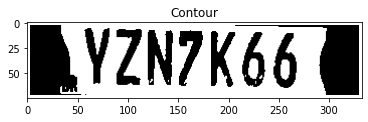

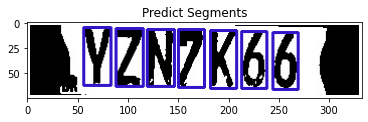

1/1 [==============================] - 0s 32ms/step


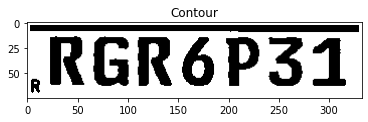

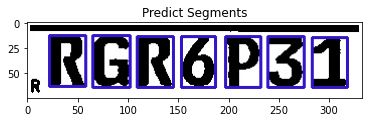

1/1 [==============================] - 0s 49ms/step


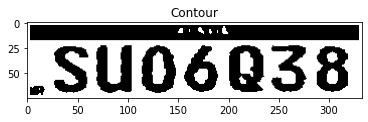

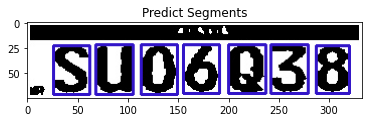

1/1 [==============================] - 0s 31ms/step


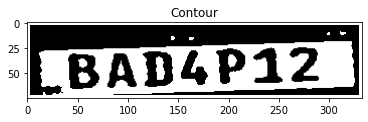

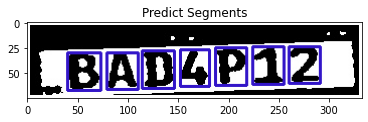

1/1 [==============================] - 0s 30ms/step


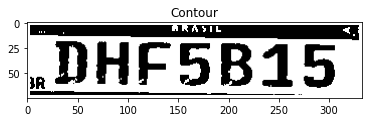

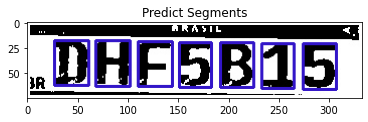

1/1 [==============================] - 0s 48ms/step


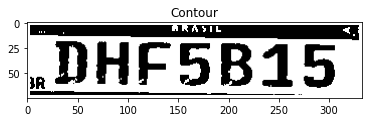

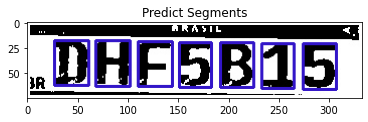

1/1 [==============================] - 0s 49ms/step


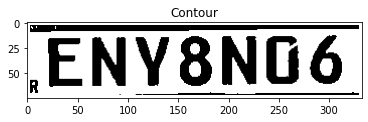

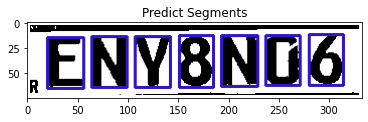

1/1 [==============================] - 0s 39ms/step


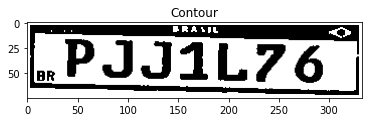

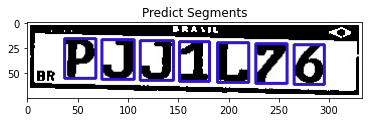

1/1 [==============================] - 0s 49ms/step


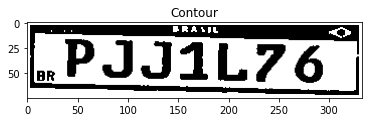

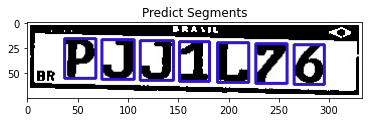

1/1 [==============================] - 0s 47ms/step


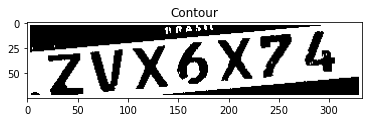

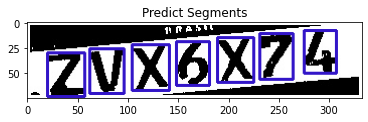

1/1 [==============================] - 0s 29ms/step


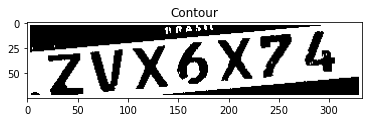

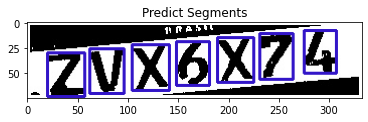

1/1 [==============================] - 0s 31ms/step


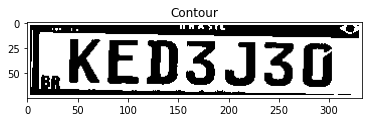

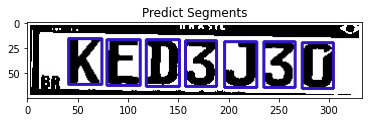

1/1 [==============================] - 0s 40ms/step


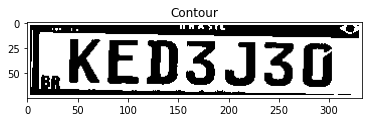

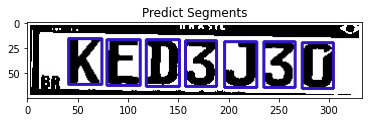

1/1 [==============================] - 0s 47ms/step


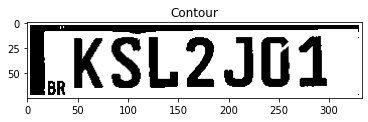

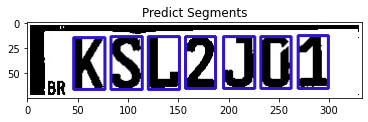

1/1 [==============================] - 0s 40ms/step


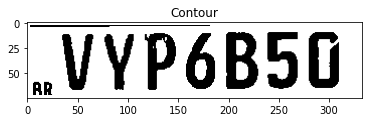

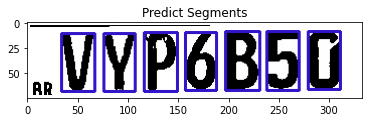

1/1 [==============================] - 0s 46ms/step


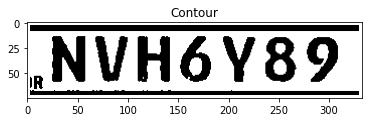

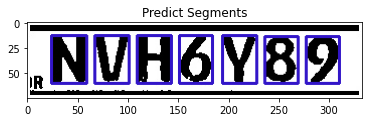

1/1 [==============================] - 0s 50ms/step


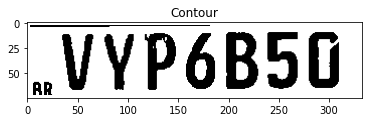

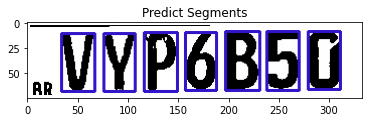

1/1 [==============================] - 0s 49ms/step


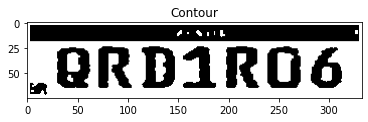

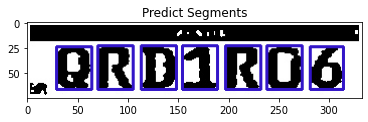

1/1 [==============================] - 0s 47ms/step


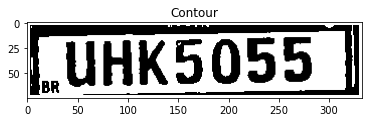

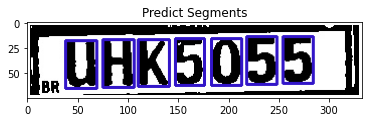

1/1 [==============================] - 0s 53ms/step


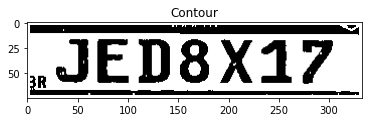

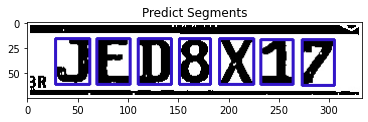

1/1 [==============================] - 0s 55ms/step


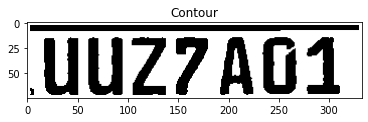

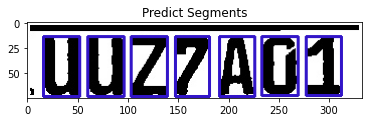

1/1 [==============================] - 0s 48ms/step


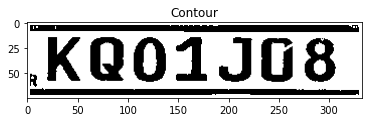

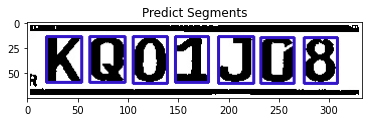

1/1 [==============================] - 0s 44ms/step


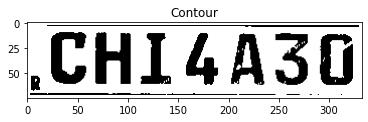

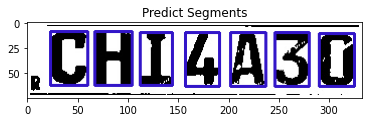

1/1 [==============================] - 0s 50ms/step


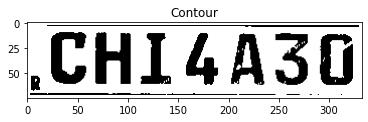

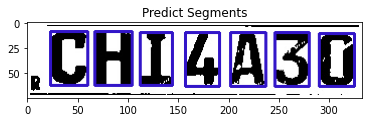

1/1 [==============================] - 0s 48ms/step


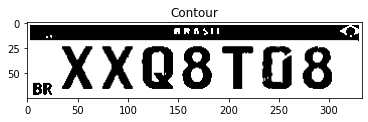

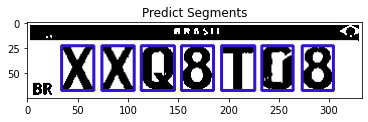

1/1 [==============================] - 0s 49ms/step


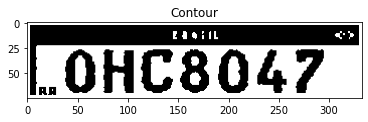

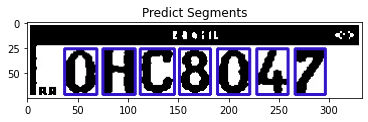

1/1 [==============================] - 0s 57ms/step


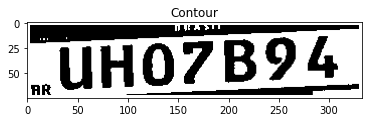

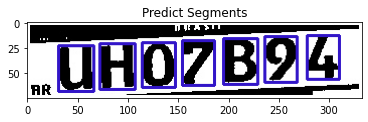

1/1 [==============================] - 0s 53ms/step


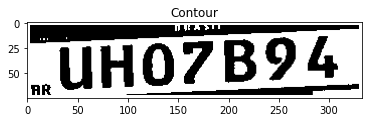

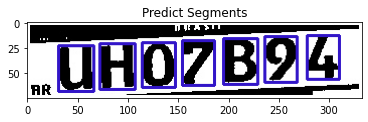

1/1 [==============================] - 0s 50ms/step


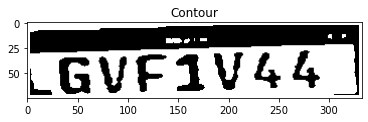

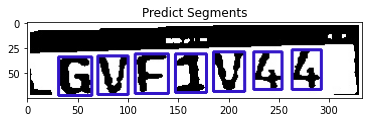

1/1 [==============================] - 0s 46ms/step


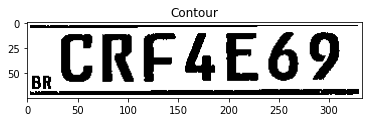

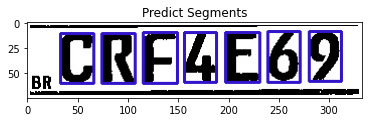

1/1 [==============================] - 0s 55ms/step


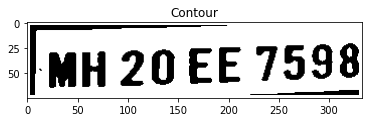

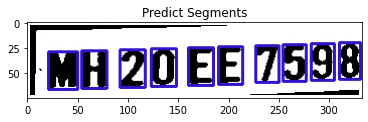

1/1 [==============================] - 0s 44ms/step


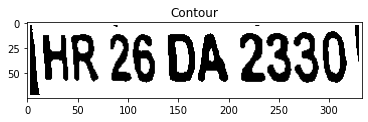

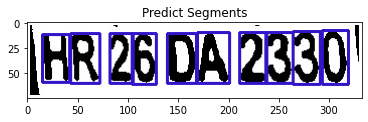

1/1 [==============================] - 0s 53ms/step


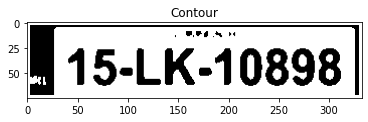

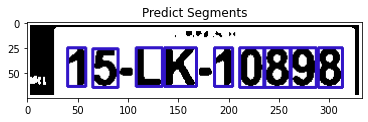

1/1 [==============================] - 0s 49ms/step


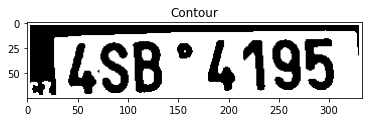

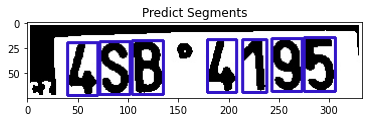

1/1 [==============================] - 0s 49ms/step


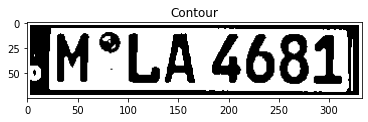

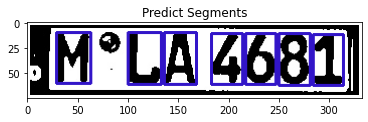

1/1 [==============================] - 0s 52ms/step


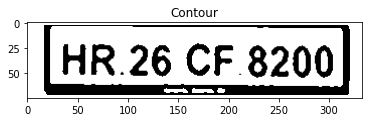

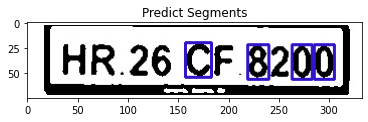

1/1 [==============================] - 0s 60ms/step


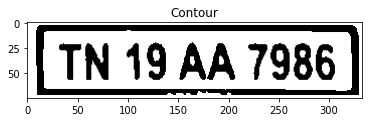

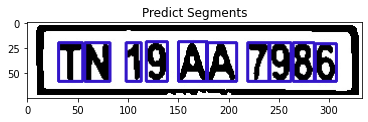

1/1 [==============================] - 0s 52ms/step


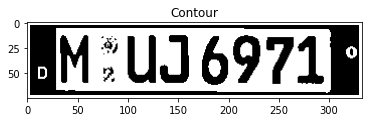

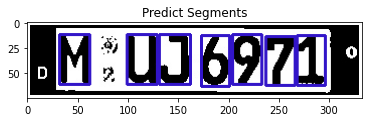

1/1 [==============================] - 0s 48ms/step


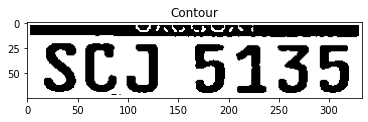

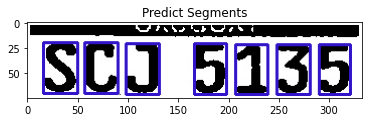

1/1 [==============================] - 0s 50ms/step


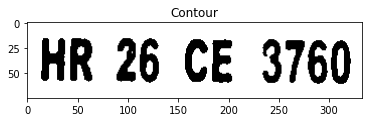

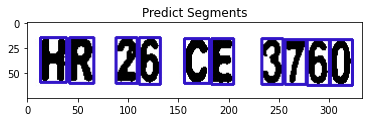

1/1 [==============================] - 0s 50ms/step


In [63]:
file_list=os.listdir(r"/content/drive/MyDrive/License-Plate-Number-Detection-main/test_dataset/images")
count=0
i=0
k1=0
empty_list=[]
for path in file_list:
#for entry in labels['ID']:
    input_path = r'/content/drive/MyDrive/License-Plate-Number-Detection-main/test_dataset/images/'+path
    is_video = False
    no=path[:-4]
  
    
    cap = cv2.VideoCapture(input_path)
    
    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:

        # get frame from the video
        hasFrame, frame = cap.read() #frame: an image object from cv2

        # Stop the program if reached end of video
        if not hasFrame:
            break

        # Create a 4D blob from a frame.
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        cropped = postprocess(frame, outs)
        if cropped is not None:
            # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            
            char=segment_characters(cropped)
            # Predicting the output
            plate=show_results1(char)
            empty_list.append(plate)
            i=i+1
        else :
            k1=k1+1
            empty_list.append('NA')


In [64]:
len(empty_list)

166

In [71]:
from difflib import SequenceMatcher
count=0
for i in range(166):
  if(SequenceMatcher(a=empty_list[i],b=labels['NUMBER'][i]).ratio() >= 0.1):
    count=count+1
print('Accuracy is :',count/166*100,'%')

Accuracy is : 71.6867469879518 %
